# Neighbors, Clusters, Classification

By [Allison Parrish](http://www.decontextualize.com/)

(Note: Rough draft! Notes incomplete. But very usable!)

In this notebook, I'm going to take you through a couple of simple, well-known techniques for exploring small sequences of text (like lines of poetry or sentences). These techniques include:

* Making vectors for text sequences
* Nearest-neighbor lookups for semantic similarity
* Visualizing corpora with t-SNE
* Clustering sentence vectors to discover similar items
* Classification with vectors

We're going to work with a corpus of several million lines of poetry, scraped from Project Gutenberg. Before you continue, download the file by executing the cell below:

In [ ]:
!curl -L -O http://static.decontextualize.com/gutenberg-poetry-v001.ndjson.gz

I'm going to use [spaCy](http://spacy.io/) extensively, both as a way to parse text into sentences and also as a source for pre-trained word vectors. Make sure you have it installed, along with the `en_core_web_md` or `en_core_web_lg` models. This notebook also assumes that you have [scikit-learn](https://scikit-learn.org/stable/), [numpy](https://numpy.org/) and [simpleneighbors](https://github.com/aparrish/simpleneighbors) installed.

## Sentence vectors

[Review the concept of word vectors](https://github.com/aparrish/rwet/blob/master/understanding-word-vectors.ipynb) before continuing.

Word vectors work great when we're interested in individual words. More often, though, we're interested in longer stretches of text, like sentences, lines, paragraphs. If we had a way to represent these longer stretches of text as vectors, we could perform all of the same operations on them that word vectors allow us to perform on words. But how to represent stretches of text as sequences?

There are lots of different ways! The classic technique in machine learning is to use the frequency of terms found in each sequence (methods like [tfidf](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)), or similar techniques like [doc2vec](https://rare-technologies.com/doc2vec-tutorial/). Another way is to train a neural network (like an LSTM or transformer) for the task. There are any number of pre-trained models you can download and use for this, including Google's [Universal Sentence Encoder](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html) and the [Sentence-Transformers](https://www.sbert.net/index.html) Python package.

But a surprisingly effective technique is to simply average together the word vectors for each word in the sentence. A big advantage of this technique is that *no further training is needed*, beyond the training needed to calculate the word vectors; if you're using pre-trained vectors, even that step can be skipped. You won't get state-of-the-art results on NLP benchmarks with this technique, but it's a good baseline and still useful for many tasks.

In the section below, I sample ten thousand lines of poetry from a Project Gutenberg poetry corpus and assign each a vector using this averaging technique.

In [1]:
import numpy as np
import spacy

In [2]:
import gzip, json, random

Load spacy's language model:

In [3]:
nlp = spacy.load('en_core_web_md')

And then load up all of the lines of poetry:

In [4]:
lines = []
for line in gzip.open("./gutenberg-poetry-v001.ndjson.gz"):
    data = json.loads(line)
    lines.append(data['s'])

In [5]:
len(lines)

3085117

To make things a bit faster and less memory-intensive, I'm only going to use ten thousand lines of poetry, sampled randomly. (You can change this number to something bigger if you want! But note that some of the stuff we're doing later on in the notebook will take longer.)

In [6]:
sampled_lines = random.sample(lines, 10000)

### Averages and weighted averages

Every spaCy span (i.e., documents, sentences, etc.) has a `.vector` attribute, which is calculated as the average of the vectors for each token in the span. The `summary()` function below parses the string you pass to it with spaCy and returns the vector that spaCy computes. (Here I disable the `parser`, `tagger` and `ner` [pipelines](https://spacy.io/usage/processing-pipelines) in order to make the process faster. We're just after the tokens and vectors—we don't need parts of speech, etc.)

In [7]:
def summary(sent):
    return nlp(sent, disable=['parser', 'tagger', 'ner']).vector

The code in the cell below computes "summary vectors" for the lines of poetry sampled above:

In [8]:
embeddings = [summary(line) for line in sampled_lines]

And here's what they look like:

In [10]:
rand_idx = random.randrange(len(sampled_lines))
sampled_lines[rand_idx], embeddings[rand_idx]

('(Her brother he) this costly present gave.',
 array([-1.75622299e-01,  1.32986456e-01, -8.44215900e-02,  4.82430980e-02,
         1.74502004e-02, -8.76883119e-02,  1.76149942e-02, -3.61497015e-01,
        -5.74538112e-02,  2.43268013e+00, -1.48494095e-01,  2.99035579e-01,
         1.11827075e-01, -1.91019416e-01, -1.60742804e-01,  1.32711336e-01,
        -3.05573996e-02,  8.21499228e-01, -1.68846309e-01,  5.52493632e-02,
         3.93133946e-02, -1.54419899e-01, -1.10142693e-01,  8.04464519e-02,
         6.40499145e-02, -2.25680182e-03, -4.54931036e-02, -1.31961077e-01,
        -6.36553019e-02, -7.24741071e-02, -6.74557984e-02,  7.51990154e-02,
        -9.89093930e-02,  3.45098961e-04,  9.51817632e-02, -8.35796669e-02,
         6.16111644e-02,  2.46332996e-02,  1.22698285e-01, -8.34121853e-02,
         1.00834802e-01,  2.57775076e-02,  1.40923887e-01, -8.89457017e-02,
         8.39405321e-03, -8.10271651e-02, -1.75619200e-01,  2.75510009e-02,
         9.43362117e-02,  4.86863144e-02,

## Build your own little search engine

Sentence vectors aren't especially interesting on their own! One thing we can use them for is to build a tiny "search engine" based on semantic similarity between lines. To do this, we need to be able to calculate the distance between a target sentence's vector (not necessarily a sentence from our corpus) and vectors of the sentences in the corpus, returning them ranked based on the distance between the two vectors. However, doing this comparison is computationally expensive and potentially very slow. Instead, we'll use an *approximate* nearest neighbors algorithm, which uses some tricks to make the computation faster, at the cost of a little bit of accuracy. I'm going to use the Simple Neighbors package as a way to build an approximate nearest neighbors index quickly and easily.

In [12]:
from simpleneighbors import SimpleNeighbors

In the cell below, I build a nearest-neighbor lookup for the sampled lines of poetry:

In [13]:
lookup = SimpleNeighbors(300)
for vec, line in zip(embeddings, sampled_lines):
    lookup.add_one(line, vec)
lookup.build()

The `.nearest()` method returns the sentences from the corpus whose vectors are closest to the vector you pass in. The code in the cell below uses the `summary()` function to return the sentences most similar to the sentence you type in. The number controls how many sentences should be returned.

In [15]:
lookup.nearest(summary("I don't want the words, I want the sound."), 5)

['I do you wrong?  I do not hear your praise',
 'I think you know it. Fitzwalter, I can save you,',
 "Mother, if you don't mind, I should like to become the boatman of",
 "I tell them they can't get me through the door, though:",
 'And I would tell it all to you;']

To get neighbors for a random item in the corpus:

In [16]:
lookup.neighbors(random.choice(lookup.corpus))

['Wild winds went straying,',
 'Of wailing winds, and naked woods, and meadows brown and sere.',
 'Girt with rough skins, hies to the deserts wild,',
 'On Cowper Green I stray, tis a desert strange and chill,',
 'To slay wild beasts and chase the roving hind,',
 'And, brightly leaping down the hills,',
 'With thicket overgrown, grotesque and wild,',
 "No--'twas the wind that, whirring, rose,",
 'To bear her cloudy flame,',
 'The little rills, and waters numberless,',
 'Walked hog-eyed Allen, terror of the hills',
 'Sat upon a grassy hillock,']

## Visualize poem space in two dimensions

Another thing you can do with sentence vectors is *visualize* them. But the vectors are large (in our case, 300 dimensions), which doesn't have an obvious mapping to 2-dimensional space. Thankfully, there are a number of algorithms to *reduce* the dimensionality of vectors. We're going to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ("t-distributed stochastic neighbor embedding"), but there are others to experiment with that might be just as good or better for your application (like [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA) or [UMAP](https://umap-learn.readthedocs.io/en/latest/)).

Note in the code below, I'm using an even smaller subset of the data. (That's what the `[:2000]` is doing—just using the first 2000 samples. This is because t-SNE is *slow*, as is drawing the results of a t-SNE).

In [17]:
from sklearn.manifold import TSNE
mapped_embeddings = TSNE(n_components=2,
                         metric='cosine',
                         init='pca',
                         verbose=1).fit_transform(embeddings[:2000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.103510
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.455208
[t-SNE] KL divergence after 1000 iterations: 2.354854


The following line draws a very large image with the results of the t-SNE. (You might want to right-click to save the image and then bring it up in an image viewer to see the details.)

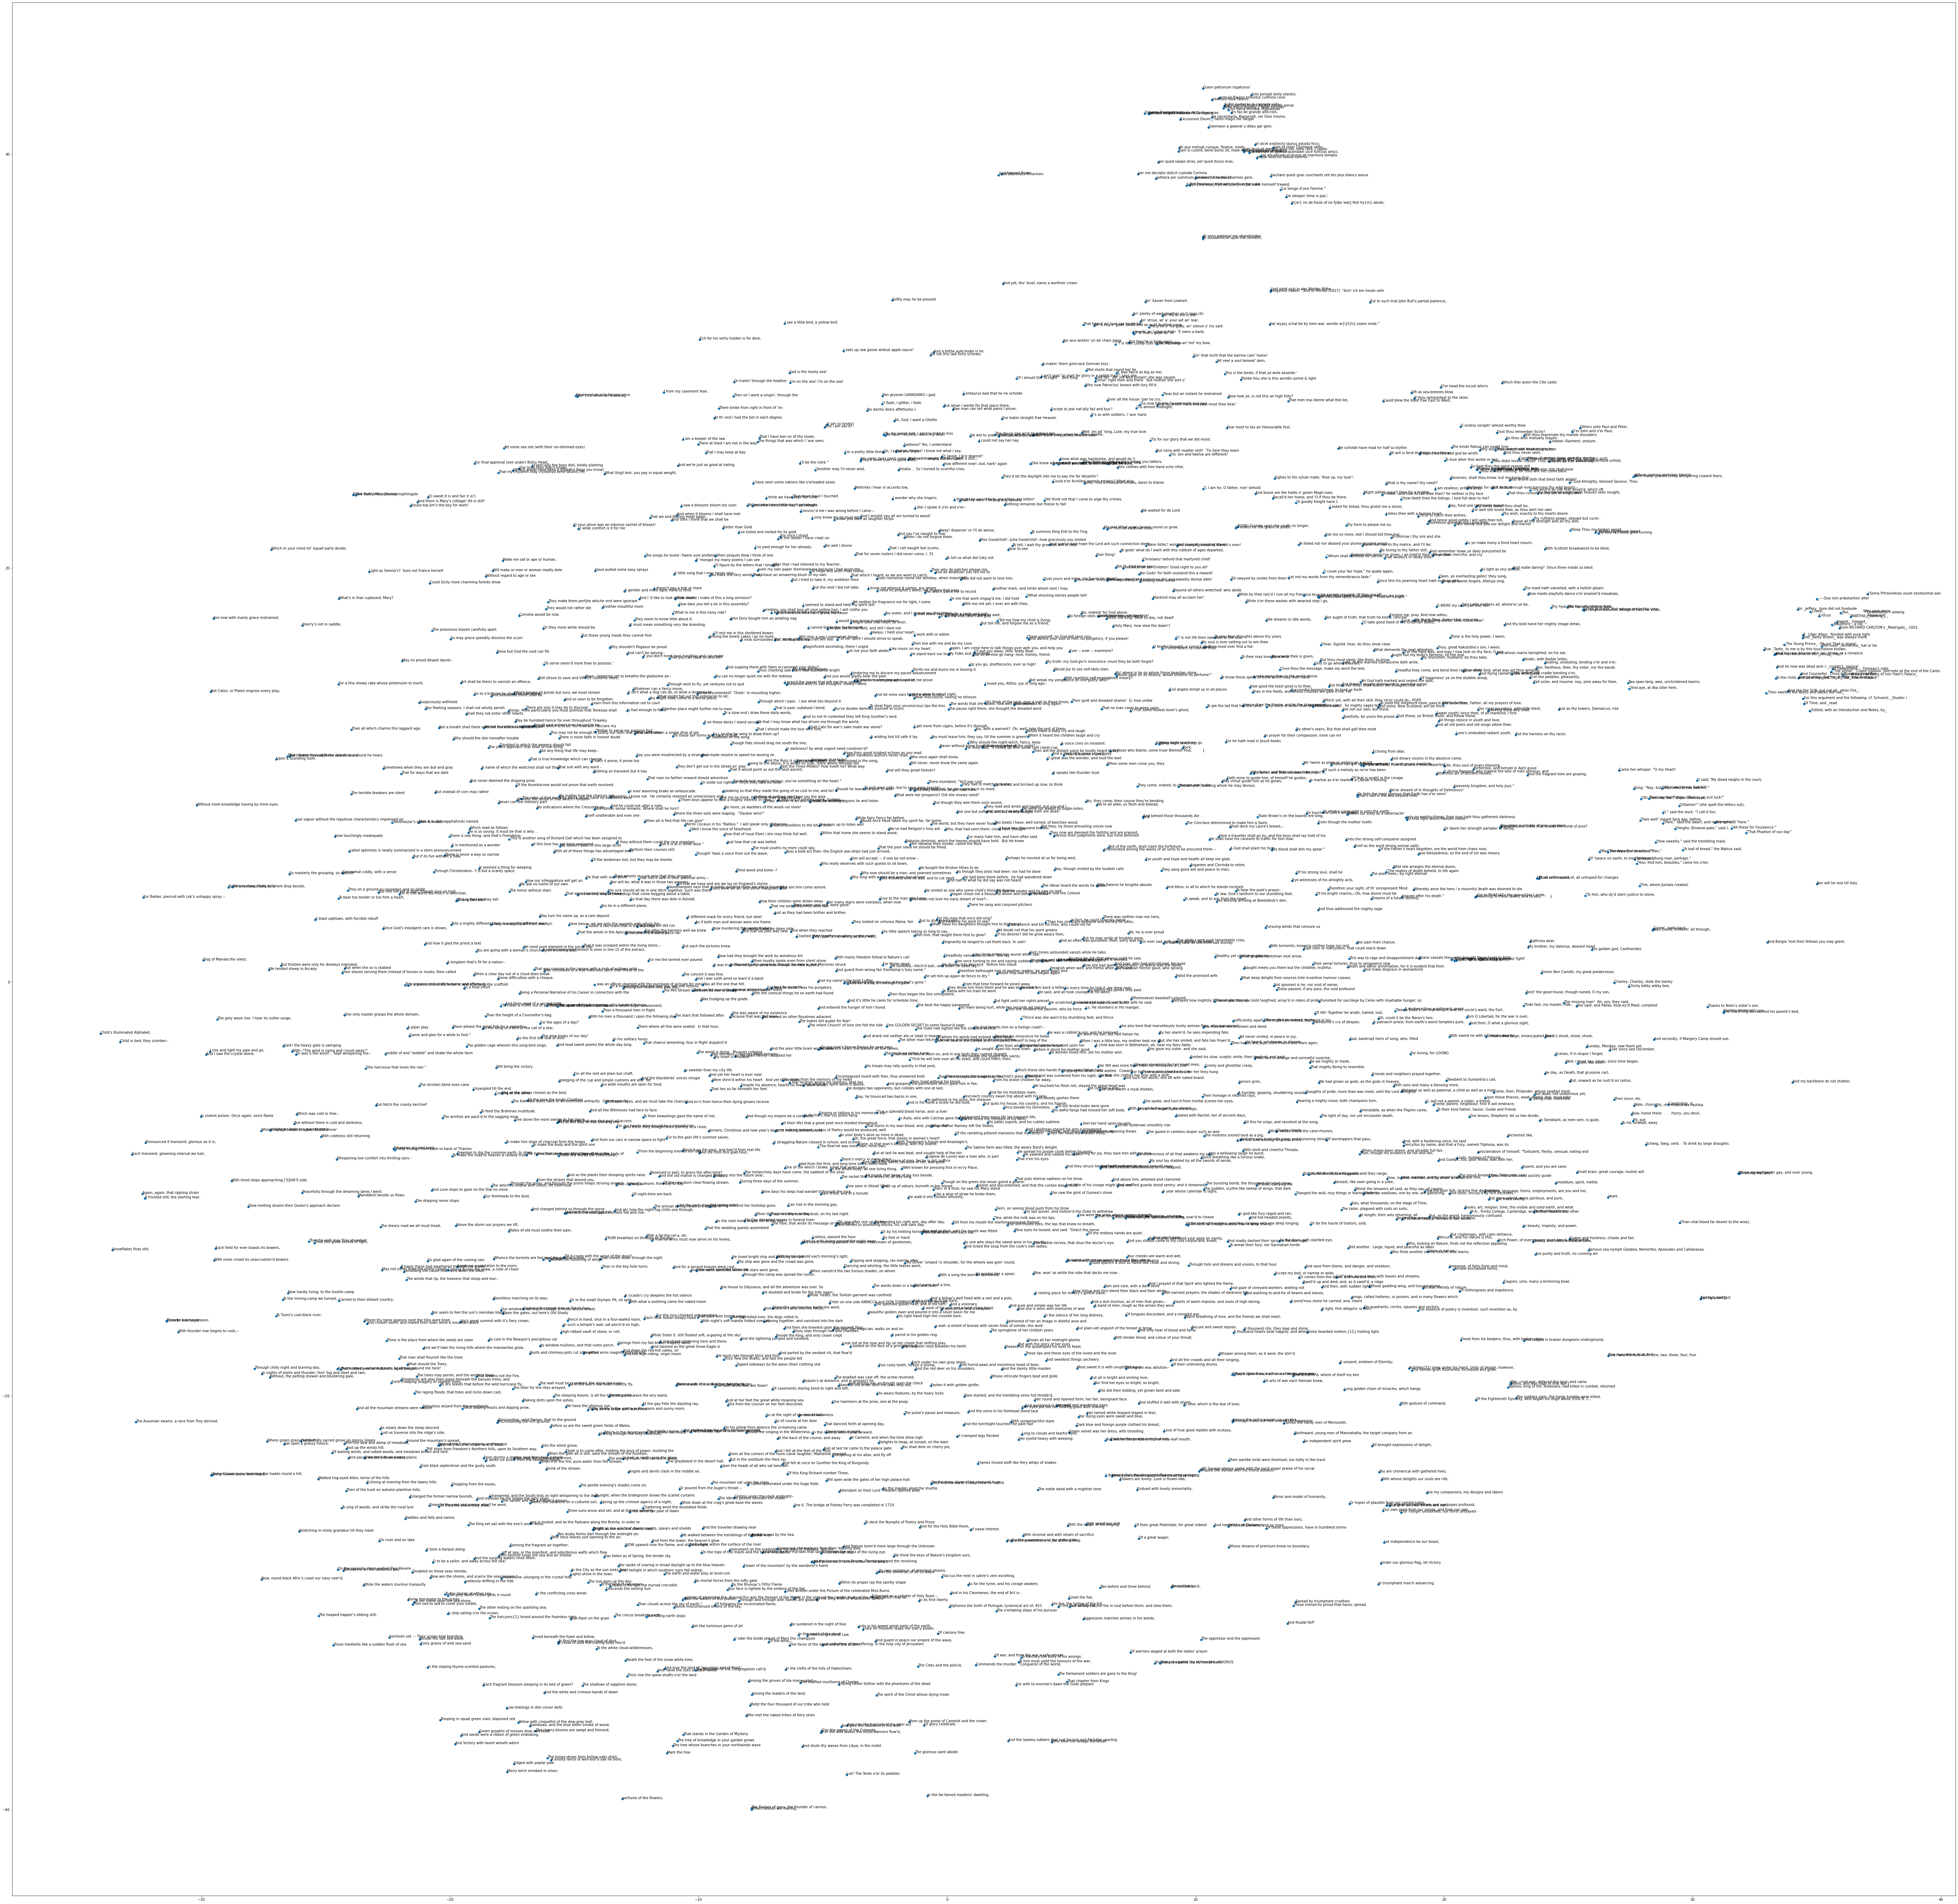

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(sampled_lines[:2000]):
    plt.annotate(txt, (x[i], y[i]))

### Exporting for Google Embedding Projector

[The Google Embedding Projector](https://projector.tensorflow.org/) is a handy web-based tool for exploring and visualizing data using different dimensional reduction techniques. The code in the following cells exports the data from our lines of poetry and embeddings in a format that you can upload to the tool:

In [20]:
with open("emb-proj-vecs.tsv", "w") as fh:
    for vec in embeddings[:2000]:
        fh.write("\t".join(["%0.5f" % val for val in vec]))
        fh.write("\n")

In [21]:
with open("emb-proj-labels.tsv", "w") as fh:
    fh.write("\n".join(sampled_lines[:2000]))

Click on the "Load" button in the interface, and upload the `emb-proj-vecs.tsv` file as "Vectors" and `emb-proj-labels.tsv` as "Metadata."

## Finding clusters

In the visualization above, you may have seen some evidence of "clustering"—groups of items that seem to be related. There are algorithms that facilitate finding such clusters *automatically*. This can be an interesting and valuable way to explore your data—you might find clusters of meaning that you didn't expect.

We're going to use the [K-Means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) (in particular, scikit-learn's [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

In [22]:
cluster_count = 25 # adjust this until it starts giving you good results!

In [24]:
from sklearn.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=cluster_count)
clusters = clusterer.fit_predict(embeddings)

In [25]:
from collections import defaultdict
group_by_cluster = defaultdict(list)

In [26]:
for i, item in enumerate(clusters):
    group_by_cluster[item].append(sampled_lines[i])

In [28]:
for i in range(cluster_count):
    print(f"Cluster {i} ({len(group_by_cluster[i])} items)")
    print("Closest to center: ", lookup.nearest(clusterer.cluster_centers_[i], 1)[0])
    print()
    print("\n".join(random.sample(group_by_cluster[i],
                  min(8, len(group_by_cluster[i])))))
    print("\n---")

Cluster 0 (2 items)
Closest to center:  Out of old graves arose the cry of life;

Beneath whose shade the graves of heroes lie;
Out of old graves arose the cry of life;

---
Cluster 1 (665 items)
Closest to center:  scenery. The river Peneus ran through it, but not with the

And where within the surface of the river
With power to walk at will the ocean-floor,
Could Sicily more charming forests show
The crocus breaking earth;
The dreary road we all must tread,
Is pumped up brisk now, through the main ventricle,
While the waters murmur tranquilly
The sunlight leaves behind,

---
Cluster 2 (352 items)
Closest to center:  she fated to redeem one man of them from an evil doom. So

Curse their own soul.
Well deemed the little God his ancient sway was o'er.
And now a mighty shade of me shall go beneath the earth!
And from his holy lips these accents broke:
Like eternities of ice!
This caravan of life passes in curious guise! Be on thy
(On her soul may our Lady have gramercy!)
That human heart

## Classifying texts

Sentence vectors make it easy to classify texts—i.e., based on an existing labelled corpus, predict what category some new text will fall into. Let's build a simple classifier that tries to determine whether a given stretch of text is more like a line of poetry or more like a sentence from a recipe book. First, download the plaintext version of [this book](http://www.gutenberg.org/ebooks/26209) and put it in the same directory as this notebook. (You might go in and remove the Gutenberg boilerplate, but you don't have to.)

The following cell parses this text into sentences:

In [29]:
recipe_sents = [sent.text.strip() for sent in nlp(open("./pg26209.txt").read().replace("\n", " "),
                                          disable=['tagger', 'ner']).sents]

In [30]:
len(recipe_sents)

3254

In [31]:
random.sample(recipe_sents, 10)

['They should be cut with a jagging iron.',
 'If the sauce is too thick add a little more water.',
 'When it boils stir a beaten egg quickly into it, remove at once from the fire.',
 'It is better that the dough be made the day before the cakes are to be baked that it may dry a little, as they are spoiled if too much flour is added.',
 'Not till one hour after the last vegetarian did the first meat-eater appear, completely exhausted.',
 '101',
 'VENISON CAKES (a Norwegian Recipe).',
 'SPICED CURRANTS.',
 'Put a layer of the tomatoes in a baking dish, season with salt, pepper and a little sugar, cover with a layer of bread crumbs, dot freely with bits of butter, then put another layer of tomatoes, and lastly a layer of bread crumbs, with bits of butter, and sprinkle with a dessertspoonful of sugar.',
 'And everyone who eats flesh meat has part in that brutalization; everyone who uses what they provide is guilty of this degradation of his fellow-men.']

We'll pick exactly as many lines from our poetry corpus as the number of sentences we found in the recipe book. (This is cheating a little bit, since most machine learning classification algorithms work best with "balanced classes.")

In [32]:
classify_poem_lines = random.sample(lines, len(recipe_sents))

A classifier tries to predict a category *y* based on some data *X*. The machine learning algorithm is essentially trying to approximate a function *y = f(X)* that most accurately gives the corresponding labels *y* for each value in *X*. Our *X* is going to be the sentence vector for each sentence, and our *y* is going to be 0 for poetry, 1 for recipe. (Category labels should always be integers; starting with 0 and counting up is best.)

In [39]:
X = [] # embeddings of lines
y = [] # categories of lines
all_text = [] # actual text

In [40]:
for text in classify_poem_lines:
    all_text.append(text)
    X.append(summary(text))
    y.append(0) # 0 for poem
for text in recipe_sents:
    all_text.append(text)
    X.append(summary(text))
    y.append(1) # 1 for recipes

Validate that our categories are even:

In [41]:
from collections import Counter
Counter(y).most_common()

[(0, 3254), (1, 3254)]

Any classifier has a 50% chance of getting any guess correct. So for our classifier to be any good, it has to be able to predict with a greater than 50% chance.

### Train/test split

We'll train the model with some of our data, and set aside some of the data for testing the model. It's important to set aside testing data as a way to validate that the model is accurate on data that it has never seen. The `train_test_split()` function in scikit-learn is a very easy way to do this. It first shuffles the data, and then partitions it into two parts: training data (75%) and testing data (25%).

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(np.array(X), np.array(y), all_text)

In [45]:
len(X_train), len(y_train), len(text_train), len(X_test), len(y_test), len(text_test)

(4881, 4881, 4881, 1627, 1627, 1627)

Now, we're training the classifier. We won't go into the details of how the classifier works! You could drop in any other classifier, really, including a neural network. But the Random Forest Classifier works just fine and is surprisingly fast.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rfc = RandomForestClassifier(n_estimators=200, class_weight="balanced", verbose=1, n_jobs=-1)

In [48]:
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       verbose=1)

Now, we'll see how accurate the model is by *predicting* the categories in the test set.

In [49]:
preds = rfc.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [50]:
from sklearn import metrics

The accuracy score is simply a percentage of how many predictions were correct:

In [51]:
metrics.accuracy_score(y_test, preds)

0.9655808236017209

But there are other useful measures of how good the model is at classifying things:

In [52]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       796
           1       0.99      0.94      0.97       831

    accuracy                           0.97      1627
   macro avg       0.97      0.97      0.97      1627
weighted avg       0.97      0.97      0.97      1627



* precision = of items labeled X, how many were actually X?
* recall = of all items that were actually X, how many were labeled X?
* f1 score: weighted average of the two.

Let's try classifying individual, randomly-selected items. (Remember, 0 is poem, 1 is recipe.)

In [53]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict([X_test[rand_idx]]), text_test[rand_idx])

[0] Which lifts plain life to the divine,


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


The `.predict_proba()` method gives us the *probability* of each category, rather than just the category. The first item in the square brackets is the probability of category 0 (i.e., poem), and the second item is the probability of category 1 (i.e., recipe). The larger the number, the more probable the text belongs to that category (according to the classifier).

In [54]:
rand_idx = random.randrange(len(X_test))
print(rfc.predict_proba([X_test[rand_idx]]), text_test[rand_idx])

[[0.835 0.165]] But when a day or two confirms her stay


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Predicting everything in the test set along with probabilities:

In [55]:
preds_with_prob = rfc.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In the test set, here are the items deemed most likely to be poetry, along with their predicted probabilities and true category:

In [56]:
for idx in np.argsort(preds_with_prob[:,0])[-10:]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

His hand that trembled as one terrifyde; [0.995 0.005] 0
He falls, earth thunders, and his arms resound. [1. 0.] 0
"Oh, what reck I thy gold?" quoth Earl Sigurd, the bold; [1. 0.] 0
And menaced vengeance, ere he reach'd his shore; [1. 0.] 0
I'll be a missionarer like her oldest brother, Dan, [1. 0.] 0
Still he did not cease his singing, [1. 0.] 0
He, anger'd by his father, roam'd away [1. 0.] 0
That, kneeling in the silence of his tent, [1. 0.] 0
Mine eyes true-opening, and my heart much eased; [1. 0.] 0
Unto the dumb lips of the flock he lent      Sad, pleading words, showing how man, who prays [1. 0.] 1


Likewise, those deemed most likely to be from the recipe book:

In [57]:
for idx in np.argsort(preds_with_prob[:,0])[:10]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

Serve with tomato sauce, or around a dish of stewed tomatoes. [0. 1.] 1
EGGS IN A BROWN SAUCE. [0. 1.] 1
Butter a mould, sprinkle with bread crumbs, pour the pudding into it and set it in a pan of hot water in a moderate oven. [0. 1.] 1
APPLE MERINGUE. [0. 1.] 1
|    18.1 [0. 1.] 1
Butter a mould, sprinkle with fine bread crumbs, take the buns out of the custard, lay them in the mould and pour the custard over them. [0. 1.] 1
Three egg yolks, a pint and a half of cream, three-quarters of a pound of butter, an even teaspoonful of soda, one pound and a half of sugar, and flour enough to roll. [0. 1.] 1
Pare, core and quarter eight or nine good cooking apples, put them into a double boiler with two tablespoonfuls of butter, half a cup of sugar, the juice and grated rind of a lemon; cook until tender. [0. 1.] 1
Put all into a saucepan with only water enough to cook them tender, cover tightly, when done, brown a little butter and flour together to make the gravy [0. 1.] 1
|   6.6 [0. 1.] 1


The most ambiguous items (i.e., the items whose probabilities are closest to 50% for each category):

In [58]:
diffs = np.abs(preds_with_prob[:,0] - preds_with_prob[:,1])

In [59]:
for idx in np.argsort(diffs)[:20]:
    print(text_test[idx], preds_with_prob[idx], y_test[idx])

It will become clear. [0.495 0.505] 1
Hard [0.505 0.495] 1
And we’ll carry home some watter [0.505 0.495] 0
O was an orange [0.51 0.49] 0
The vegetarian can extract from his food all the principles necessary for the growth and support of the body, as well as for the production of heat and force. [0.49 0.51] 1
We do not solicit donations in locations where we have not received written confirmation of compliance. [0.51 0.49] 1
They are very nice but very troublesome to prepare. [0.51 0.49] 1
Nearly all the individual works in the collection are in the public domain in the United States. [0.485 0.515] 1
Despite these efforts, Project Gutenberg-tm electronic works, and the medium on which they may be stored, may contain "Defects," such as, but not limited to, incomplete, inaccurate or corrupt data, transcription errors, a copyright or other intellectual property infringement, a defective or damaged disk or other medium, a computer virus, or computer codes that damage or cannot be read by y

Finally, lines of poetry deemed to be recipe-like:

In [60]:
recipelike = []
for idx in np.argsort(preds_with_prob[:,0]):
    if y_test[idx] == 0:
        recipelike.append((text_test[idx], preds_with_prob[idx]))
for item, score in recipelike[:12]:
    print(item, score)

Though strawberries and raspberries, [0.115 0.885]
To prune these growing Plants, & tend these Flours, [0.295 0.705]
Stir of sweet enlightenments; [0.355 0.645]
Is a little red house with a little straw cap [0.435 0.565]
saved. [0.445 0.555]
And for no less than aromatic wine [0.455 0.545]
And we’ll carry home some watter [0.505 0.495]
O was an orange [0.51 0.49]
Cypris jam nova, jam recens, [0.515 0.485]
Simple Cottage was clear and clean, [0.525 0.475]
Lincoln, our more than Washington. [0.535 0.465]
Lux coruscat fulgida: [0.535 0.465]


And poem-like recipe sentences:

In [61]:
poemlike = []
for idx in np.argsort(preds_with_prob[:,1]):
    if y_test[idx] == 1:
        poemlike.append((text_test[idx], preds_with_prob[idx]))
for item, score in poemlike[:12]:
    print(item, score)

Unto the dumb lips of the flock he lent      Sad, pleading words, showing how man, who prays [1. 0.]
One day I was speaking to an authority on this subject, and I asked him how it was that he knew so decidedly that most of the murders and the crimes with the knife were perpetrated by that particular class of men, and his answer was suggestive, although horrible. [0.975 0.025]
"Suffer the ox to plough, and impute his death to age and Nature's         hand. [0.975 0.025]
He that killeth an ox is as if he slew a man.--Isaiah lxvi. [0.965 0.035]
Then said Daniel to Melzar [the steward], whom the prince of the eunuchs had set over Daniel, Hananiah, Mishael, and Azariah: Prove thy servants, I beseech thee, ten days; and let them give us pulse to eat, and water to drink. [0.96 0.04]
as the one dieth, so dieth the other; yea, they have all one breath; so that a man hath no preeminence above a beast: for all is vanity. [0.945 0.055]
THE CHRIST IDEAL WRITTEN                          WITHIN, IN T

You can predict the category of an arbitrary sentence by first vectorizing it use the same method you used to vectorize the sentences in the model, then passing it to `.predict()`:

In [63]:
rfc.predict_proba([summary("Roses are red, violets are blue")])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


array([[0.675, 0.325]])

This tells us the model believes the sentence we gave it is a bit more likely to be poetry than a recipe. You can repeat this for an entire text! the following cell reads in the contents of a file line by line, calculates the vectors for those lines, and runs the prediction on them:

In [81]:
file_lines = [line.strip() for line in open("sonnets.txt").readlines() if len(line.strip()) > 0]
file_vecs = [summary(line) for line in file_lines]
file_probs = rfc.predict_proba(file_vecs)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


And now we can sort the text according to its most recipe-like lines:

In [82]:
idx = np.argsort(file_probs[:,0])
for i in idx[:25]:
    print(frost_probs[i], frost_lines[i])

[0.435 0.565] Like stones of worth they thinly placed are,
[0.46 0.54] Growing a bath and healthful remedy,
[0.49 0.51] Which should example where your equal grew.
[0.495 0.505] Love's fire heats water, water cools not love.
[0.5 0.5] Or bends with the remover to remove:
[0.525 0.475] Or whether revolution be the same.
[0.535 0.465] And brought to medicine a healthful state
[0.54 0.46] So far from variation or quick change?
[0.54 0.46] Which works on leases of short-number'd hours,
[0.545 0.455] The worth of that is that which it contains,
[0.56 0.44] With eager compounds we our palate urge;
[0.57 0.43] Than public means which public manners breeds.
[0.58 0.42] To set a form upon desired change,
[0.585 0.415] Some fresher stamp of the time-bettering days.
[0.585 0.415] And the firm soil win of the watery main,
[0.59 0.41] Each changing place with that which goes before,
[0.595 0.405] They are but dressings of a former sight.
[0.595 0.405] For when these quicker elements are gone
[0.595